<a href="https://colab.research.google.com/github/vladop22/PRA3024-Analysis-of-Big-Data-in-Physics/blob/main/GW_exercise_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

PART 1

In [28]:
import sys
!{sys.executable} -m pip install lalsuite pycbc

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [29]:
#Firstly, we have to import the important libraries/packages for data analysis, visualization, and computing
%matplotlib inline
import pylab
import lal
from pycbc.filter import highpass,matched_filter,sigmasq
from pycbc.conversions import mass1_from_mchirp_q
from pycbc.catalog import Merger
from pycbc.frame import read_frame
from pycbc.filter import resample_to_delta_t, highpass
import numpy as np
from pycbc import types
from pycbc.waveform import get_td_waveform,get_fd_waveform
from pycbc.waveform import td_approximants, fd_approximants
import pycbc.psd
from pycbc.psd import interpolate

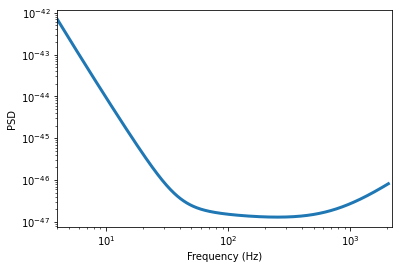

In [30]:
#Then, we need to generate power spectral density (psd) for the advanced Ligo detector
# set up the variables to set up the frequency domain signal/calculate psd:
flow = 4   #the low-frequency cutoff, set to 4Hz
delta_f = 1.0 / 16 # the frequency resolution, set to 1/16 Hz
flen = int(2048.0/ (delta_f)) + 1 # the length of the frequency domain signa, 129 in this case

#calculating the psd:
psd = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, flow) 

psd.data[:int(flow/delta_f)] = np.inf  # setting the psd to infinity for these frequencies essentially removes them from the analysis.
psd.data[-1] = np.inf # the nyquist frequency is the maximum frequency that can be sampled given our sampling rate we defined. In our case, it's 1024Hz

# plotting the psd vs frequency 
pylab.loglog(psd.sample_frequencies, psd, linewidth=3, label='aLIGOZeroDetHighPower');
pylab.xlim(xmin = flow, xmax = 2200);
pylab.xlabel('Frequency (Hz)');
pylab.ylabel('PSD');

In [31]:
# We can use a couple of relationships to define a function that will calculate the horizon distance given the values of psd and a range of masses.
# D is inversely proportional to ρ and D_H corresponds to ρ = 8
# Therefore, D_H = (D_1 * ρ_1)/8. ρ_1 will be calculated for the range of masses D_1 = 100Mp
def get_horizon_distances(masses,psd,delta_f,flow):
  D_Hs=[]
  for m in masses:
    hp, hc = get_fd_waveform(approximant="TaylorF2", #generating the waveform under the assumption that m_1 = m_2
                         mass1 = m, 
                         mass2 = m, 
                         delta_f = delta_f , 
                         distance = 1000,  #D_1
                         f_lower=flow,)
    
    #calculating the signal-to-nooise ratio (SNR) of the waveform 'hp' w.r.t. given psd value
    SNR=(sigmasq(hp,psd))**0.5 # sigmasq calculates the matched filter output variance for the given 'hp' and 'psd' values
    #Calculating the horizon distance

    D_H=(1000*(SNR))/8 #calculating the luminosity distance under the assumption that the source is a binary neutron star system, and the masses of the objects are known.  
    D_Hs.append(D_H) # the factor '1000' in the equation above is converting the distance from MPc to kpc
  return D_Hs

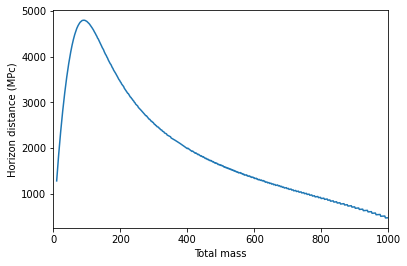

In [35]:
masses=np.arange(5,500,1) # creates an array/range of masses from 5 to 500 in increments of 1.
DH_aligo=get_horizon_distances(masses,psd,delta_f,flow) #calculates the horizon distance for each mass value defined in the range above 
# the returned values are saved as an array in the DH_aligo

mass_t=2*masses #calculates the total mass

pylab.plot(mass_t,DH_aligo); #plotting the horizon distance in Mpc vs the total mass (solar masses)
pylab.xlim(xmin = 0, xmax=1000);
pylab.xlabel('Total mass');
pylab.ylabel('Horizon distance (MPc)');

PART 2

Since we know that the horizon distance is proportional to ρ, and we know that $\rho^2=4\int _0^{∞}\frac{|\tilde{h}(f)|^2}{S_h(f)}$, where $S_h(f)$ represents the noise power spectral density (npsd), we can conclude the following statement:
the horizon distance must be inversely proportional to the square root of the npsd. This means that for increasing values of npsd, the horizon distance becomes smaller. 
GW signals that are generated by massive objects are characterized by lower frequencies and higher amplitudes. It follows that when the masses of the objects are too large, the detector will struggle to observe the signal since the frequencies characterizing the signal lie in the range of high npsd. Additionally, this explains why the horizon distance decreases after a certain mass limit. Each detector, depending on its sensibility, will have a maximal range of detection of compact binry mergers. This is known as the 'sensitivity band' of the detector. It is important to take the sensitivity band into consideration when analyzing the data and making certain predictions about the possible detectibility of the signal from different sources of GW signal production.  

PART 3

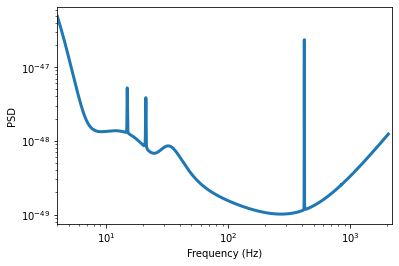

In [33]:
psd_E = pycbc.psd.EinsteinTelescopeP1600143(flen, delta_f, flow) # calculates the psd for the proposed Einstein telescope
# flen is set to the length of the frequency vector

psd_E.data[:int(flow/delta_f)] = np.inf #set to infinity, repeating the same step as done in a few cells above
psd_E.data[-1] = np.inf 

#plotting psd vs frequency 
pylab.loglog(psd_E.sample_frequencies, psd_E, linewidth = 3, label = 'EinsteinTelescopeP1600143');
pylab.xlim(xmin = flow, xmax = 2200);
pylab.xlabel('Frequency (Hz)');
pylab.ylabel('PSD');

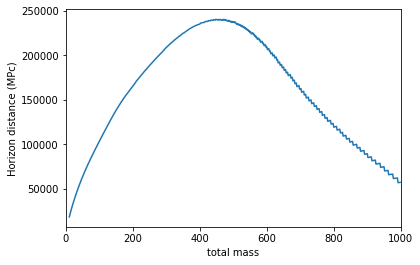

In [34]:
DH_einstein=get_horizon_distances(masses,psd_E,delta_f,flow) #calculating the horizon distances into an array DH_einstein

#Plotting the horizon distance in MPc vs the total mass expressed in solar masses
pylab.plot(mass_t,DH_einstein);
pylab.xlim(xmin = 0, xmax=1000);
pylab.xlabel('total mass');
pylab.ylabel('Horizon distance (MPc)');

As explained in Part 2 of this exercise, the lower the npsd value, the higher the horizon distance. This is observed in the plot of psd vs frequency of the Einstein Telescope shown above.